In [67]:
import os
import sys
import shutil
import re
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
if 'SUMO_HOME' in os.environ:
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
import traci
import traci.constants as tc
import sumolib
import xml.etree.ElementTree as ET


FOLDER_NAME = 'ufscar'

In [3]:
sumoBinary = "/usr/bin/sumo-gui"
sumoCmd = [sumoBinary, "-c", "osm.sumocfg"]

In [4]:
# Code of each variable to subscribe:
SPEED = 64
POSITION = 66
ACCELERATION = 114
ANGLE = 67
DEPATURE = 58

# Simulating and getting the data

In [5]:
def flush_print():
    sys.stdout.write("\r")  # Move the cursor to the beginning of the line
    sys.stdout.write(" " * 50)  # Overwrite with spaces to clear the line
    sys.stdout.write("\r")  # Move back to the beginning again

In [6]:
def setSpeedMode(vehID, speedMode):
    # bit0: Regard safe speed
    # bit1: Regard maximum acceleration
    # bit2: Regard maximum deceleration
    # bit3: Regard right of way at intersections (only applies to approaching foe vehicles outside the intersection)
    # bit4: Brake hard to avoid passing a red light
    # bit5: Disregard right of way within intersections (only applies to foe vehicles that have entered the intersection)

    # CAUTION: 
    # bit5 has inverted semantics and must be set to '1' in order to disable the safety function. This achieves backward compatibility with earlier versions of SUMO where this bit was not defined and right of way within intersection could not be ignored explicitly.

    if vehID in traci.vehicle.getIDList():
        traci.vehicle.setSpeedMode(vehID, speedMode)

In [7]:
def setSpeed(vehID, speed):
    # Sets the speed of the vehicle to max(speed, MaxVehicleSpeed)
    if vehID in traci.vehicle.getIDList():
        traci.vehicle.setSpeed(vehID, speed)

In [8]:
def slowDown(vehID, targetSpeed, duration):
    # Slows down the vehicle to targetSpeed over the next duration seconds
    if vehID in traci.vehicle.getIDList():
        traci.vehicle.slowDown(vehID, targetSpeed, duration)

In [9]:
def get_all_variables(vehIDs, personIDs, useGui=False):
    if useGui:
        traci.start(["sumo-gui", "-c", f"{FOLDER_NAME}/osm.sumocfg"])
    else:
        traci.start(["sumo", "-c", f"{FOLDER_NAME}/osm.sumocfg"])
    v_variables = {}
    p_variables = {}
    time = 0
    vehIDs = set(vehIDs)
    while traci.simulation.getMinExpectedNumber() > 0:

        for veh_id in (set(traci.simulation.getDepartedIDList()) & vehIDs):
            traci.vehicle.subscribe(veh_id, [tc.VAR_POSITION, tc.VAR_SPEED, tc.VAR_ACCELERATION, tc.VAR_ANGLE])
        

        # for veh_id in traci.simulation.getDepartedIDList():
        #     if veh_id in vehIDs:
        #         traci.vehicle.subscribe(veh_id, [tc.VAR_POSITION, tc.VAR_SPEED, tc.VAR_ACCELERATION, tc.VAR_ANGLE])
        
        # for person_id in traci.simulation.getDepartedPersonIDList():
        #     if person_id in personIDs:
        #         traci.person.subscribe(person_id, [tc.VAR_POSITION, tc.VAR_SPEED])

        v_variables[time] = traci.vehicle.getAllSubscriptionResults().copy()
        # p_variables[time] = traci.person.getAllSubscriptionResults().copy()

        # if time == 100:
        #     traci.vehicle.setType("veh2", "v_super_aggressive1")
        #     traci.vehicle.setType("veh4", "v_cautious0")
        
        time += 1
        traci.simulationStep()
        
    traci.close()
    return v_variables, p_variables

In [10]:
def get_departure_arrival(variables, ID):
    # Devolve o tempo de depareture e arrival de um veículo ou pessoa
    departure = 0
    arrival = 0
    departed = False
    arrived = False
    for x in range(len(variables)):
        if ID in variables[x] and variables[x][ID] and not departed:
            departed = True
            departure = x
        elif ID not in variables[x] and departed:
            arrival = x
            arrived = True
            break
    if not arrived:
        arrival = len(variables)
    return departure, arrival

Função para o plot das variáveis

In [11]:
def extract_vtype_ids(folder_name):
    root = ET.parse(f"{folder_name}/merged.rou.alt.xml").getroot()
    ids_random = {}
    ids_routine = {}
    for vehicle in root.findall('vehicle'):
        v_type = re.sub(r'\d+', '', vehicle.get('type').split('_', 1)[1])
        vID = vehicle.get('id')

        if vID.startswith('veh'):
            if v_type not in ids_routine.keys():
                ids_routine[v_type] = []

            ids_routine[v_type].append(vID)

        else:
            if v_type not in ids_random.keys():
                ids_random[v_type] = []

            ids_random[v_type].append(vID)

    return ids_routine, ids_random

In [12]:
# IDs of vehicles and persons to subscribe
type_ids_routine, type_ids_random = extract_vtype_ids('ufscar')

# Flatten the type_ids_random values into a 1D array
type_ids_random_1d = [item for sublist in type_ids_random.values() for item in sublist]

# WARNING: ALWAYS LET THE LAST VEHICLES BE THE ONES WITH ROUTINES
vehIDs = type_ids_random_1d
# IMPORTANT: Make sure the IDs are strings
vehIDs = [f'{i}' for i in vehIDs]
personIDs = []

In [68]:
try:
    veh_variables, ped_variables = get_all_variables(vehIDs, personIDs, useGui=False) # Running the simulation
except Exception as e:
    traci.close() # Close the simulation if there is an error
    print(f"An error occurred: {e}")

 Retrying in 1 seconds
***Starting server on port 54373 ***
Loading net-file from 'ufscar/osm.net.xml.gz' ... done (106ms).
Loading additional-files from 'ufscar/park.add.xml' ... done (18ms).
Loading additional-files from 'ufscar/pa_rerouter.xml' ... done (169ms).
Loading route-files incrementally from 'ufscar/merged.rou.alt.xml'
Loading done.
Simulation version 1.22.0 started with time: 0.00.


Simulation ended at time: 1986.70.
Reason: TraCI requested termination.
Performance:
 Duration: 200.52s
 TraCI-Duration: 23.58s
 Real time factor: 9.90774
 UPS: 4962.053660
Vehicles:
 Inserted: 638
 Running: 0
 Waiting: 0
 Teleports: 2 (Jam: 1, Wrong Lane: 1)
 Emergency Braking: 11
Statistics (avg of 638):
 RouteLength: 2077.92
 Speed: 14.17
 Duration: 155.95
 WaitingTime: 2.52
 TimeLoss: 52.16
 DepartDelay: 3.04
DijkstraRouter answered 664 queries and explored 404.73 edges on average.
DijkstraRouter spent 0.12s answering queries (0.18ms on average).


# Saving the data

In [69]:
def save_data_dirty(veh_variables, data_folder_name, vehIDs, type_ids_random, type_ids_routine=None):

    if not os.path.exists(f'{FOLDER_NAME}/{data_folder_name}'):
        os.mkdir(f'{FOLDER_NAME}/{data_folder_name}')
    else:
        shutil.rmtree(f'{FOLDER_NAME}/{data_folder_name}')
        os.mkdir(f'{FOLDER_NAME}/{data_folder_name}')

    for timestep, data in veh_variables.items():
        for vehID, vehData in data.items():

            if not os.path.exists(f'{FOLDER_NAME}/{data_folder_name}/{vehID}.csv'):
                with open(f'{FOLDER_NAME}/{data_folder_name}/{vehID}.csv', 'w') as f:
                    f.write('time,x_pos,y_pos,speed,acceleration,angle\n')

            with open(f'{FOLDER_NAME}/{data_folder_name}/{vehID}.csv', 'a') as f:
                f.write(f'{timestep},{vehData[POSITION][0]},{vehData[POSITION][1]},{vehData[SPEED]},{vehData[ACCELERATION]},{vehData[ANGLE]}\n')
        
    # Creating the labels file
    with open(f'{FOLDER_NAME}/{data_folder_name}/labels.csv', 'w') as f:
        f.write('ID,Type\n')
        found = False
        for i in range(len(vehIDs)):

            for key, value in type_ids_random.items():
                if vehIDs[i] in str(value):
                    f.write(f'{vehIDs[i]},{key}\n')
                    found = True
                    break
            
            if type_ids_routine and not found:
                for key, value in type_ids_routine.items():
                    if vehIDs[i] in value:
                        f.write(f'{vehIDs[i]},{key}\n')
                        break

In [70]:
def plot_df(ids, folder_path, sensors, normalize_time=True, time_window=[]):
    num_ids = len(ids)
    num_rows = (num_ids + 1) // 2  # Calculate the number of rows needed with 2 plots per row

    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 5 * num_rows), sharex=True)
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for i, veh_id in enumerate(ids):
        csv_path = f'{folder_path}/{veh_id}.csv'
        df = pd.read_csv(csv_path)

        # Convert numerical columns to float
        df["speed"] = df["speed"].values.astype(float)
        df["acceleration"] = df["acceleration"].values.astype(float)
        df["angle"] = df["angle"].values.astype(float)

        # Shift the time so that it starts at zero
        if normalize_time:
            df["time"] = df["time"] - df["time"].min()
        
        # Limit the time window if specified
        if time_window:
            df = df[(df["time"] >= time_window[0]) & (df["time"] <= time_window[1])]

        # Plot each selected sensor in its own subplot
        for sensor in sensors:
            if sensor == "speed":
                axes[i].plot(df["time"], df["speed"], color="b", label="Speed")
            elif sensor == "acceleration":
                axes[i].plot(df["time"], df["acceleration"], color="r", label="Acceleration")
            elif sensor == "angle":
                axes[i].plot(df["time"], df["angle"], color="g", label="Angle")

        axes[i].set_ylabel("Value")
        axes[i].set_title(f"Vehicle {veh_id} over Time")
        axes[i].legend()

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show plot
    plt.show()


## Sometimes there will be teleporting to avoid deadlock

This causes anomalies in the data that must me solved

In [71]:
save_data_dirty(veh_variables, "data_dirty", vehIDs, type_ids_random, type_ids_routine=None)

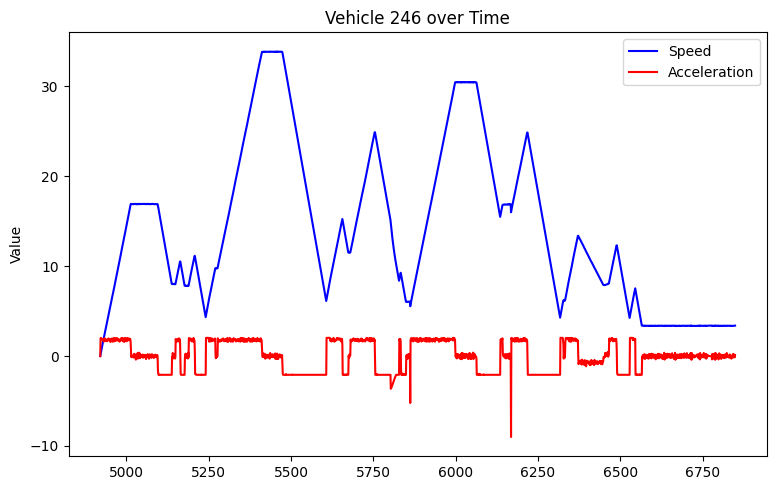

In [88]:
plot_df(['246'], f'{FOLDER_NAME}/data_dirty', ['speed', 'acceleration'], normalize_time=False, time_window=[])

To solve this problem, one idea is to identify places where the changes are too abrupt using an approximate derivative and substitute it for the previus value

In [73]:
def save_data(veh_variables, data_folder_name, vehIDs, type_ids_random, type_ids_routine=None, speed_threshold=6, acc_threshold=6, derivative_threshold=3):

    if not os.path.exists(f'{FOLDER_NAME}/{data_folder_name}'):
        os.mkdir(f'{FOLDER_NAME}/{data_folder_name}')
    else:
        shutil.rmtree(f'{FOLDER_NAME}/{data_folder_name}')
        os.mkdir(f'{FOLDER_NAME}/{data_folder_name}')

    for timestep, data in veh_variables.items():
        for vehID, vehData in data.items():

            if not os.path.exists(f'{FOLDER_NAME}/{data_folder_name}/{vehID}.csv'):
                with open(f'{FOLDER_NAME}/{data_folder_name}/{vehID}.csv', 'w') as f:
                    f.write('time,x_pos,y_pos,speed,acceleration,angle\n')

            with open(f'{FOLDER_NAME}/{data_folder_name}/{vehID}.csv', 'a') as f:

                derivative_threshold
                try: 
                    derivative_speed = (veh_variables[timestep][vehID][SPEED] - veh_variables[timestep-derivative_threshold][vehID][SPEED]) / derivative_threshold
                    derivative_acceleration = (veh_variables[timestep][vehID][ACCELERATION] - veh_variables[timestep-derivative_threshold][vehID][ACCELERATION]) / derivative_threshold
                except:
                    derivative_speed = 0
                    derivative_acceleration = 0

                write_speed = vehData[SPEED]
                write_angle = vehData[ANGLE]
                write_acc = vehData[ACCELERATION]

                # Making verification to ensure there are no outliers
                if derivative_speed > speed_threshold or derivative_speed < -speed_threshold:
                    last_speed = veh_variables[timestep-1][vehID][SPEED]
                    print(f'Vehicle {vehID} at timestep {timestep} had a speed of {vehData[SPEED]}, it was changed to {last_speed}')
                    veh_variables[timestep][vehID][SPEED] = last_speed
                    write_speed = last_speed

                if derivative_acceleration > acc_threshold or derivative_acceleration < -acc_threshold:
                    last_acc = veh_variables[timestep-1][vehID][ACCELERATION]
                    print(f'Vehicle {vehID} at timestep {timestep} had an acceleration of {vehData[ACCELERATION]}, it was changed to {last_acc}')
                    veh_variables[timestep][vehID][ACCELERATION] = last_acc
                    write_acc = last_acc
                
                if vehData[ANGLE] < 0 or vehData[ANGLE] > 360:
                    last_angle = veh_variables[timestep-1][vehID][ANGLE]
                    print(f'Vehicle {vehID} at timestep {timestep} had an angle of {vehData[ANGLE]}, it was changed to {last_angle}')
                    veh_variables[timestep][vehID][ANGLE] = last_angle
                    write_angle = last_angle

                f.write(f'{timestep},{vehData[POSITION][0]},{vehData[POSITION][1]},{write_speed},{write_acc},{write_angle}\n')
        
    # Creating the labels file
    with open(f'{FOLDER_NAME}/{data_folder_name}/labels.csv', 'w') as f:
        f.write('ID,Type\n')
        found = False
        for i in range(len(vehIDs)):

            for key, value in type_ids_random.items():
                if vehIDs[i] in str(value):
                    f.write(f'{vehIDs[i]},{key}\n')
                    found = True
                    break
            
            if type_ids_routine and not found:
                for key, value in type_ids_routine.items():
                    if vehIDs[i] in value:
                        f.write(f'{vehIDs[i]},{key}\n')
                        break

In [85]:
save_data(copy.deepcopy(veh_variables), "data", vehIDs, type_ids_random, type_ids_routine=None, speed_threshold=5, acc_threshold=4, derivative_threshold=2)

Vehicle 10 at timestep 248 had an acceleration of -4.900879279825094, it was changed to -3.331599348749048
Vehicle 3 at timestep 317 had an acceleration of -5.78000000000003, it was changed to -1.2034201819709267
Vehicle 3 at timestep 445 had an acceleration of 4.079999999999995, it was changed to -5.779999999999994
Vehicle 3 at timestep 446 had an acceleration of 4.079999999999995, it was changed to -5.779999999999994
Vehicle 3 at timestep 447 had an acceleration of 4.079999999999995, it was changed to -5.779999999999994
Vehicle 3 at timestep 448 had an acceleration of 4.079999999999995, it was changed to -5.779999999999994
Vehicle 3 at timestep 449 had an acceleration of 4.079999999999995, it was changed to -5.779999999999994
Vehicle 3 at timestep 450 had an acceleration of 4.079999999999995, it was changed to -5.779999999999994
Vehicle 3 at timestep 451 had an acceleration of 4.079999999999995, it was changed to -5.779999999999994
Vehicle 3 at timestep 453 had an acceleration of 3.2

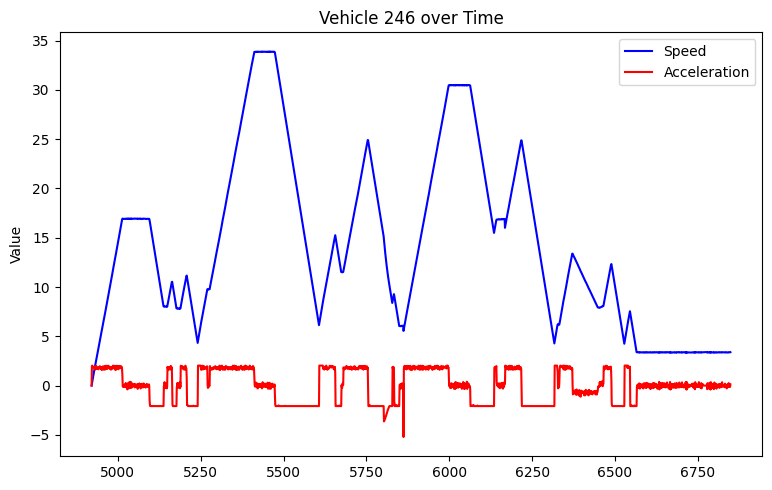

In [89]:
plot_df(['246'], f'{FOLDER_NAME}/data', ['speed', 'acceleration'], normalize_time=False, time_window=[])

## Now lets boxplot the data to see how separate they are

In [90]:
def get_whole_data(foldername, type_ids_random):
    df = {}
    for cls in type_ids_random.keys():
        cls_df = pd.DataFrame()
        for vehID in type_ids_random[cls]:
            csv_path = f'{foldername}/{vehID}.csv'
            df_temp = pd.read_csv(csv_path)
            cls_df = pd.concat([cls_df, df_temp], axis=0)
        df[cls] = cls_df  
    return df

In [91]:
def boxplots(df):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    axes = axes.flatten()
    cls = list(df.keys())

    axes[0].boxplot([df[cls[i]]['speed'] for i in range(len(df))], tick_labels=cls)
    axes[0].set_title('Speed Boxplot')
    axes[0].set_ylabel('Speed')
    axes[1].boxplot([df[cls[i]]['acceleration'] for i in range(len(df))], tick_labels=cls)
    axes[1].set_title('Acceleration Boxplot')
    axes[1].set_ylabel('Acceleration')

    plt.tight_layout()
    plt.show()

Cleaned data

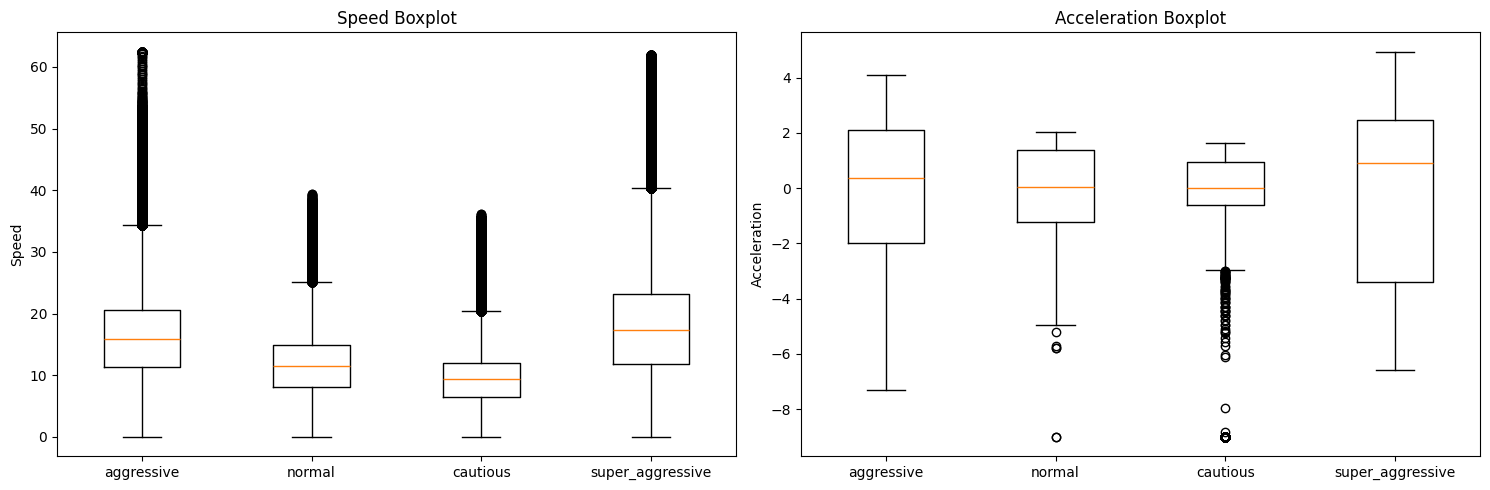

In [92]:
df = get_whole_data(f'{FOLDER_NAME}/data', type_ids_random)
boxplots(df)

Dirty data

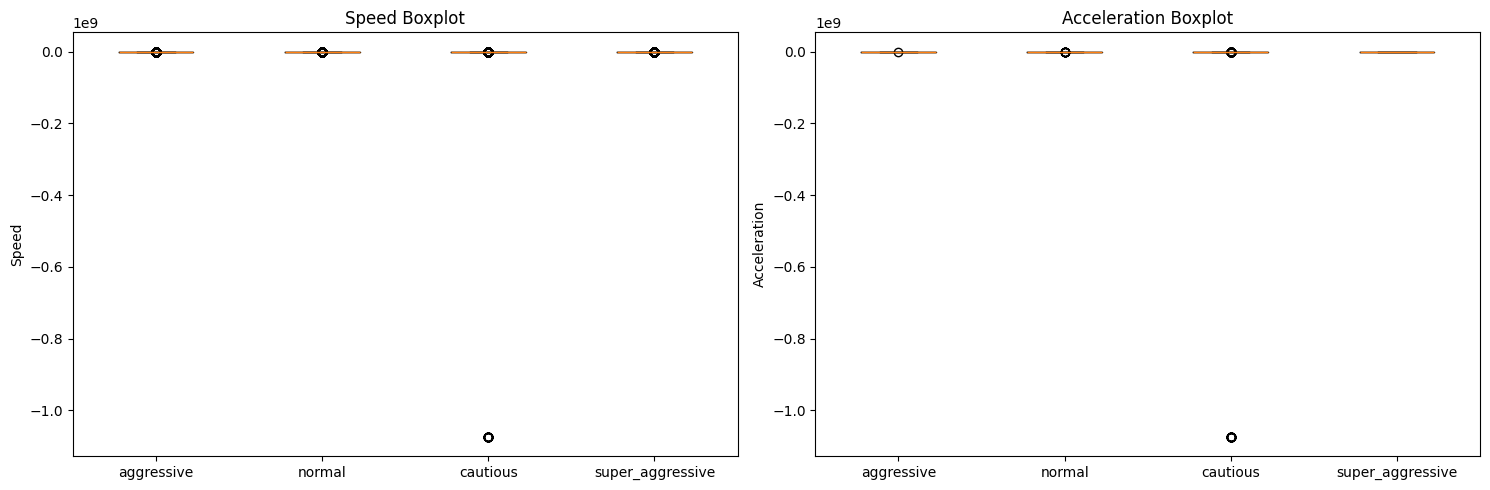

In [95]:
df_dirty = get_whole_data(f'{FOLDER_NAME}/data_dirty', type_ids_random)
boxplots(df_dirty)

They seem to be not very much separated

## Boxplot for two classes

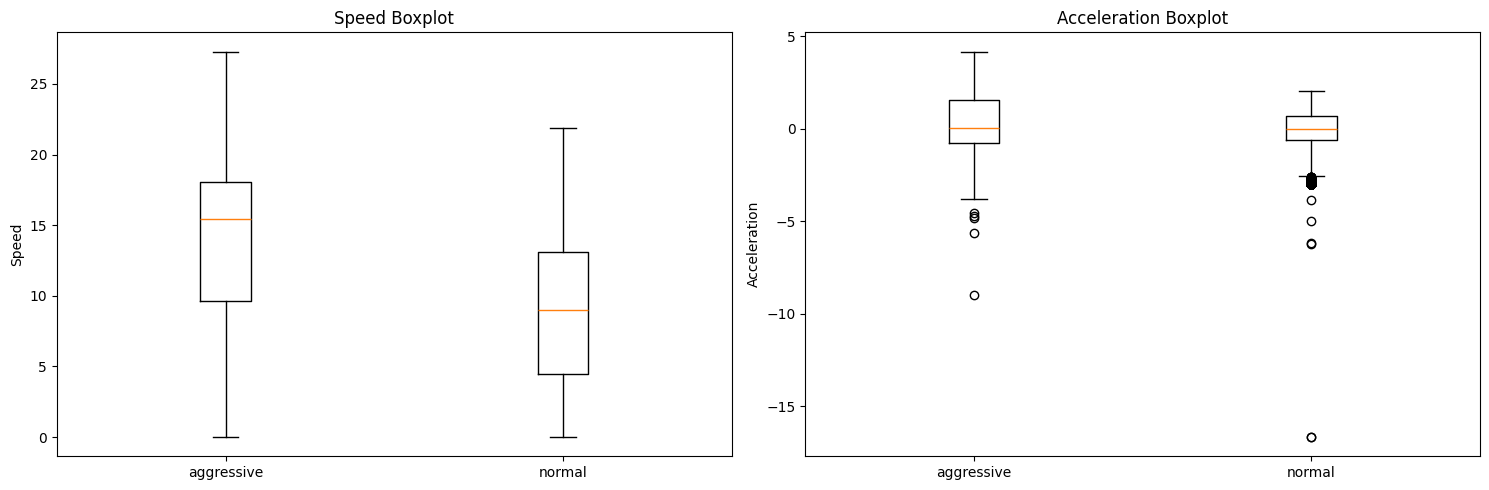

In [257]:
type_ids_routine_simple, type_ids_random_simple = extract_vtype_ids('unicamp')
df = get_whole_data(f'unicamp/data_simple', type_ids_random_simple)
boxplots(df)

## Decomposing sensors into X and Y axis

The idea here is to try to make it easier to separate the data by having more features

In [ ]:
def decompose_axis(df):
    
    return df

In [1]:
df

NameError: name 'df' is not defined

# Plots and Visualization

In [18]:
def static_plots(variables, ID, isVehicle=True):
    # Plots speed, acceleration, angle and position of a vehicle
    plt.ioff()
    departure, arrival = get_departure_arrival(variables, ID)
    time = np.arange(departure, arrival, 1.0)
    
    if isVehicle:
        fig, ax = plt.subplots(2, 2, figsize=(20, 10))
    else:
        fig, ax = plt.subplots(1, 2, figsize=(18, 5))

    if isVehicle:
        speed = [variables[x][ID][SPEED] for x in range(len(variables)) if ID in variables[x]]
        ax[0,0].plot(time, speed, label='Speed', color='b')
        ax[0,0].set_xlabel('Simulation step')
        ax[0,0].set_ylabel('Speed (m/s)')
        ax[0,0].legend()

        pos = [variables[x][ID][POSITION] for x in range(len(variables)) if ID in variables[x]]
        ax[1,1].plot([p[0] for p in pos], [p[1] for p in pos], label='Position', color='y')
        ax[1,1].set_xlabel('X pos')
        ax[1,1].set_ylabel('Y pos')

        acc = [variables[x][ID][ACCELERATION] for x in range(len(variables)) if ID in variables[x]]
        ax[0,1].plot(time, acc, color='g')
        ax[0,1].set_xlabel('Simulation step')
        ax[0,1].set_ylabel('Acceleration(m/s²)')
        ax[0,1].legend()

        angle = [variables[x][ID][ANGLE] for x in range(len(variables)) if ID in variables[x]]
        ax[1,0].plot(time, angle, color='purple')
        ax[1,0].set_xlabel('Simulation step')
        ax[1,0].set_ylabel('Angle (degrees)')

    else:
        speed = [variables[x][ID][SPEED] for x in range(len(variables)) if ID in variables[x]]
        ax[0].plot(time, speed, color='b')
        ax[0].set_xlabel('Simulation step')
        ax[0].set_ylabel('Speed (m/s)')
        ax[0].legend()

        pos = [variables[x][ID][POSITION] for x in range(len(variables)) if ID in variables[x]]
        ax[1].plot([p[0] for p in pos], [p[1] for p in pos], label='Position', color='y')
        ax[1].set_xlabel('X pos')
        ax[1].set_ylabel('Y pos')   

    plt.show()

In [19]:
def overleaf_static_plots(variables, ID, xlim, isVehicle=True):
    # Plots speed, acceleration, and angle of a vehicle
    plt.ioff()
    departure, arrival = get_departure_arrival(variables, ID)
    time = np.arange(departure, min(arrival, departure + xlim), 1.0)
    fig, ax = plt.subplots(1, 3, figsize=(25, 5))

    speed = [variables[x][ID][SPEED] for x in range(len(variables)) if ID in variables[x]]
    ax[0].plot(time, speed[:xlim], color='b')
    ax[0].set_xlabel('Simulation step')
    ax[0].set_ylabel('Speed (m/s)')
    # ax[0].set_xlim(xlim)

    acc = [variables[x][ID][ACCELERATION] for x in range(len(variables)) if ID in variables[x]]
    ax[1].plot(time, acc[:xlim], color='g')
    ax[1].set_xlabel('Simulation step')
    ax[1].set_ylabel('Acceleration (m/s²)')
    # ax[1].set_xlim(xlim)

    angle = [variables[x][ID][ANGLE] for x in range(len(variables)) if ID in variables[x]]
    ax[2].plot(time, angle[:xlim], color='purple')
    ax[2].set_xlabel('Simulation step')
    ax[2].set_ylabel('Angle (degrees)')
    # ax[2].set_xlim(xlim)

    plt.show()

In [20]:
def separate_plots(variables, sensor_values, sensor_names, vehicle_types, xlim, fig_folder = 'figs'):
    plt.ioff()

    if not os.path.exists(f'{FOLDER_NAME}/{fig_folder}'):
        os.makedirs(f'{FOLDER_NAME}/{fig_folder}')

    IDs = list(vehicle_types.keys())
    types = list(vehicle_types.values())

    times = []
    for ID in IDs:
        departure, arrival = get_departure_arrival(variables, ID)
        times.append(np.arange(departure, min(arrival, departure + xlim), 1.0))

    colors = ['r', 'g', 'b', 'black']

    for i in range(len(sensor_values)):
        fig, ax = plt.subplots(2, len(vehicle_types) // 2, figsize=(20, 10))

        for j, ID in enumerate(IDs):
            values = [variables[x][ID][sensor_values[i]] for x in range(len(variables)) if ID in variables[x]]
            time = times[j]

            row = j // (len(vehicle_types) // 2)
            col = j % (len(vehicle_types) // 2)

            if sensor_values[i] == POSITION:
                sc = ax[row, col].scatter([p[0] for p in values], [p[1] for p in values], c=[k for k in range(len(values))], cmap='viridis', label='Position')
                fig.colorbar(sc, ax=ax[row, col], orientation='vertical', label='Simulation step')
                ax[row, col].set_xlabel('x')
                ax[row, col].set_ylabel('y')
            else:
                ax[row, col].plot(time, values[:xlim], color=colors[i % len(colors)])
                ax[row, col].set_xlabel('Simulation step')
                ax[row, col].set_ylabel(sensor_names[i])

            ax[row, col].set_title(f'{vehicle_types[ID]} style')

        plt.savefig(f'{FOLDER_NAME}/{fig_folder}/{sensor_names[i].split(" ")[0]}.png')
        plt.cla()
        plt.clf()


In [21]:
def get_vehicle_types():
    routes = sumolib.xml.parse(f'{FOLDER_NAME}/finaltrips.rou.alt.xml', "vehicle")
    vehicle_types = {}
    for vehicle in routes:
        veh_id = vehicle.id
        veh_type = vehicle.type
        vehicle_types[veh_id] = veh_type
    
    return vehicle_types

In [22]:
sensor_values = [SPEED, ACCELERATION, ANGLE, POSITION] # Names of the sensors
sensor_names = ["Speed (m/s)", "Acceleration (m/s²)", "Angle (degrees)", "Position"] # Labels of the sensors

# Getting the type of each vechicle based on their IDs
vehicle_types = get_vehicle_types()
print(vehicle_types)

{'veh1': 'v_aggressive4', 'veh2': 'v_normal2', 'veh3': 'v_cautious0', 'veh4': 'v_super_aggressive3'}


ValueError: x and y must have same first dimension, but have shapes (200,) and (0,)

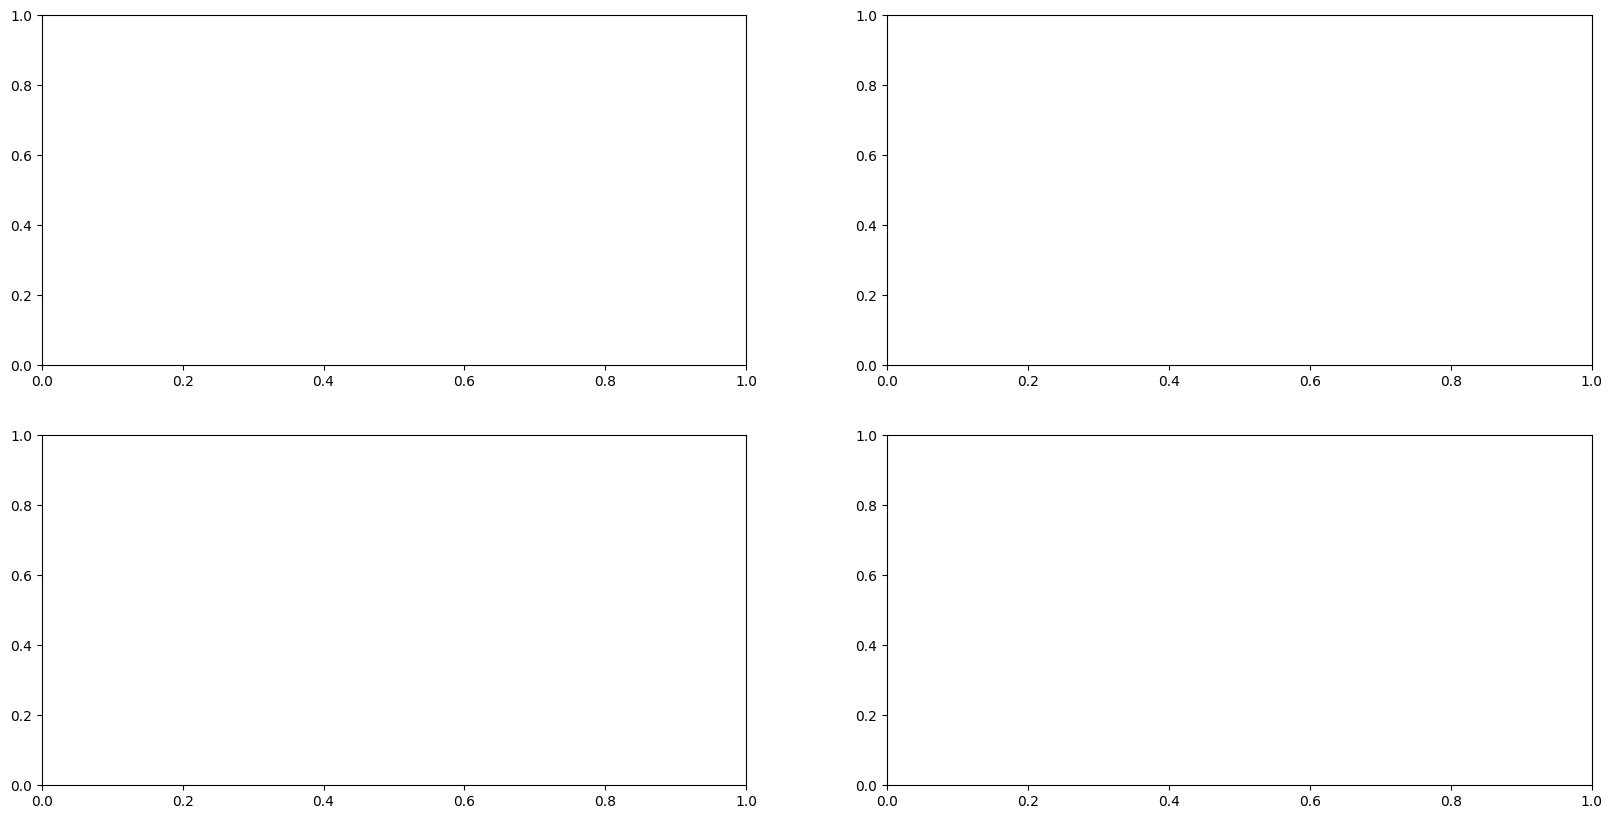

In [23]:
separate_plots(veh_variables, sensor_values, sensor_names, vehicle_types, xlim=200, fig_folder='figs') # Separate images for each sensor that are going to be saved at figs folder

/tmp/ipykernel_22301/1909441048.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0,1].legend()


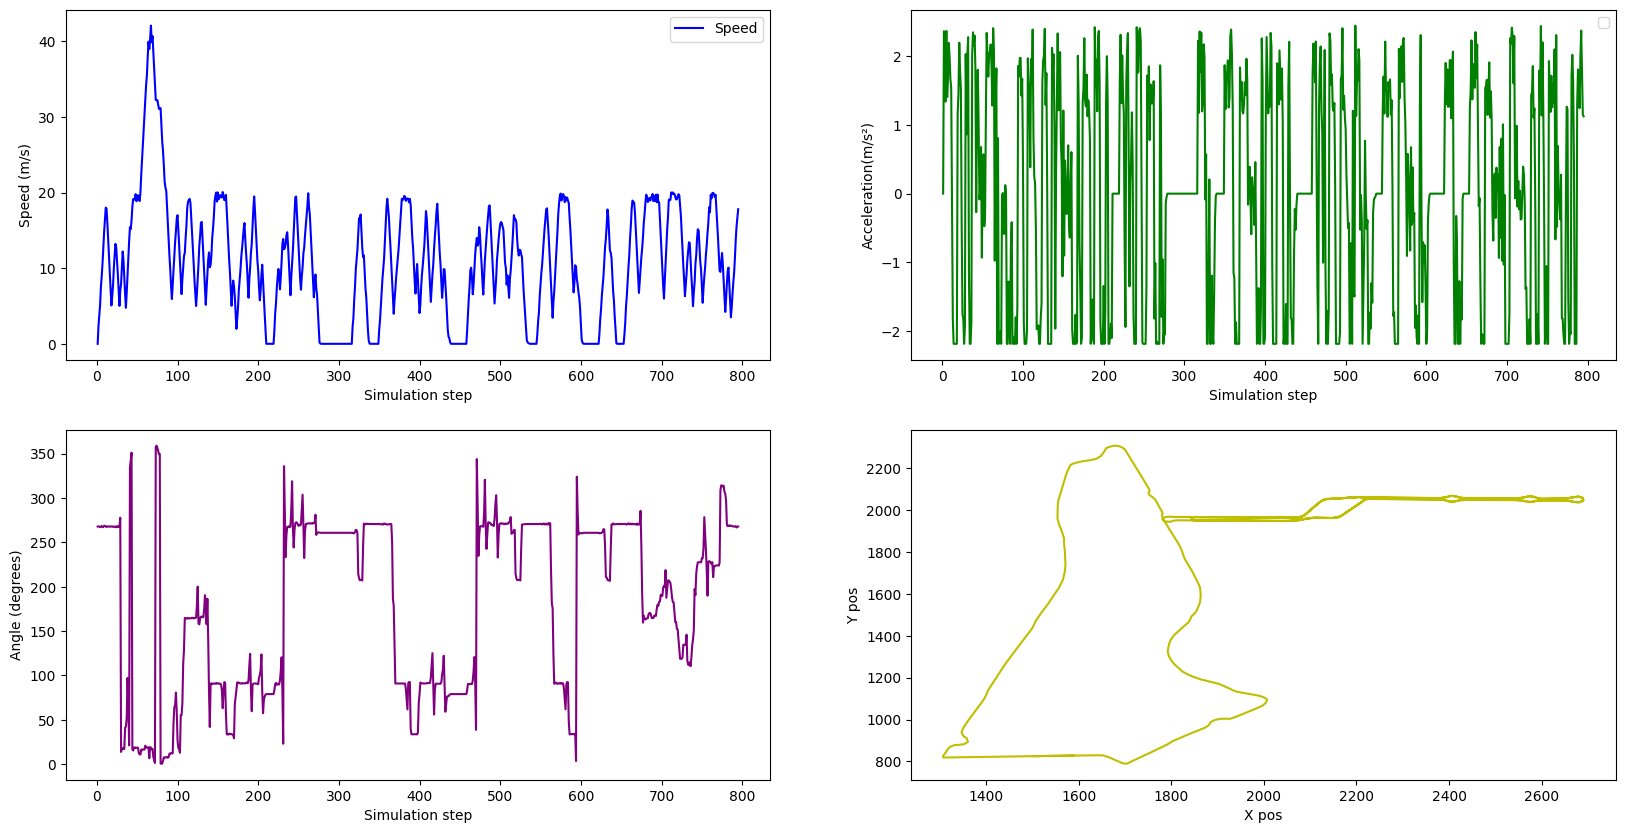

In [89]:
static_plots(veh_variables, 'veh1', isVehicle=True)

In [ ]:
# Plot para o veículo 1 (aggressive)
static_plots(veh_variables, "20", True)

Criando gráfico dinâmico que roda juntamente com a simulação: